In [19]:
import os
import re
import gzip
import lzma
import zipfile
import json
import pathlib
from itertools import chain

import base64
import inspect
import importlib

import matplotlib.colors
from natsort import natsorted

import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from scipy.stats import ttest_ind

from IPython.display import SVG, Image

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib import colormaps
from PyComplexHeatmap import *
from adjustText import adjust_text

Read modeling results and data point counts.

In [20]:
data = pd.read_csv('../analysis/modelling/all_modelling_results.tsv.xz', sep='\t')
counts = pd.read_csv('../analysis/modelling/all_modelling_counts.tsv.xz', sep='\t')

Determine counts.

In [21]:
all_data = data.merge(counts, on='accession')

In [22]:
all_data['datapoints_mutant_percentage'] = all_data.num_datapoints_mutants / all_data.num_datapoints_total * 100
all_data['balance_coeff'] = (2 * (0.5 - ((50 - all_data.datapoints_mutant_percentage) / 100).abs()))

In [23]:
total_asc_order = (all_data[(all_data.subset == 'complete') & (all_data.modeltype == 'PCM') &
                        (all_data.crossval == 'random') & (all_data.folds == 'Mean') &
                        (all_data.contains_mutants == True)]
                   .query('num_datapoints_total > 100')
                   .sort_values(['num_datapoints_total', 'num_datapoints_mutants'], ascending=False)
                   )
top20_most_order = total_asc_order.accession.iloc[:20]
bottom20_most_order = total_asc_order.accession.iloc[-20:]

In [24]:
mutant_asc_order = (all_data[(all_data.subset == 'complete') & (all_data.modeltype == 'PCM') &
                             (all_data.crossval == 'random') & (all_data.folds == 'Mean') &
                             (all_data.contains_mutants == True)]
                    .query('num_datapoints_mutants > 100')
                    .sort_values(['num_datapoints_total', 'num_datapoints_mutants'], ascending=False)
                   )
top20_mutant_order = total_asc_order.accession.iloc[:20]
bottom20_mutant_order = total_asc_order.accession.iloc[-20:]

In [25]:
balance_asc_order = (all_data[(all_data.subset == 'complete') & (all_data.modeltype == 'PCM') &
                              (all_data.crossval == 'random') & (all_data.folds == 'Mean') &
                              (all_data.contains_mutants == True)]
                     .query('num_datapoints_total > 100')
                     .sort_values('balance_coeff', ascending=False)
                     )
top20_balanced_order = balance_asc_order.accession.iloc[:20]
bottom20_balanced_order = balance_asc_order.accession.iloc[-20:]

In [26]:
all_data

folds  number          R2       MSE      RMSE      MSLE     RMSLE  \
0      Fold 1     4.0  -18.963951  1.915666  1.384076  0.025973  0.161162   
1      Fold 2     4.0  -38.603712  0.485145  0.696524  0.008415  0.091734   
2      Fold 3     4.0  -16.444156  0.485275  0.696617  0.008416  0.091740   
3      Fold 4     4.0  -36.660599  0.646585  0.804105  0.009831  0.099151   
4      Fold 5     4.0 -704.363244  5.515059  2.348416  0.105129  0.324236   
...       ...     ...         ...       ...       ...       ...       ...   
21555  Fold 3   673.0    0.381401  0.558842  0.747557  0.009605  0.098005   
21556  Fold 4   673.0    0.526424  0.472153  0.687134  0.007793  0.088277   
21557  Fold 5   673.0    0.470196  0.511106  0.714917  0.008435  0.091843   
21558    Mean   673.0    0.478716  0.513423  0.716199  0.008642  0.092894   
21559      SD     0.0    0.048058  0.028754  0.020042  0.000605  0.003242   

            MAE  Explained Variance  Max Error  ...    subset  \
0      1.364290            0.433292   1.729147  ...    common   
1      0.677614           -1.121192   0.947373  ...    common   
2      0.677479            0.054686   0.949180  ...    common   
3      0.795803            0.226351   0.983381  ...    common   
4      2.345309           -0.865143   2.526364  ...    common   
...         ...                 ...        ...  ...       ...   
21555  0.515271            0.381941   6.858958  ...  complete   
21556  0.519613            0.526487   2.705204  ...  complete   
21557  0.539227            0.471337   3.030335  ...  complete   
21558  0.527602            0.480161   3.847433  ...  complete   
21559  0.010881            0.048444   1.396598  ...  complete   

       contains_mutants  modeltype    crossval  \
0                  True        PCM  per mutant   
1                  True        PCM  per mutant   
2                  True        PCM  per mutant   
3                  True        PCM  per mutant   
4                  True        PCM  per mutant   
...                 ...        ...         ...   
21555              True       QSAR      random   
21556              True       QSAR      random   
21557              True       QSAR      random   
21558              True       QSAR      random   
21559              True       QSAR      random   

                                                    path  \
0      ..\data\modelling\pcm_common_subset_mutantspli...   
1      ..\data\modelling\pcm_common_subset_mutantspli...   
2      ..\data\modelling\pcm_common_subset_mutantspli...   
3      ..\data\modelling\pcm_common_subset_mutantspli...   
4      ..\data\modelling\pcm_common_subset_mutantspli...   
...                                                  ...   
21555      ..\data\modelling\qsar_randomsplit_Q99705.tsv   
21556      ..\data\modelling\qsar_randomsplit_Q99705.tsv   
21557      ..\data\modelling\qsar_randomsplit_Q99705.tsv   
21558      ..\data\modelling\qsar_randomsplit_Q99705.tsv   
21559      ..\data\modelling\qsar_randomsplit_Q99705.tsv   

       num_datapoints_total  num_datapoints_WT  num_datapoints_mutants  \
0                     261.0              245.0                    16.0   
1                     261.0              245.0                    16.0   
2                     261.0              245.0                    16.0   
3                     261.0              245.0                    16.0   
4                     261.0              245.0                    16.0   
...                     ...                ...                     ...   
21555                3365.0             3358.0                     7.0   
21556                3365.0             3358.0                     7.0   
21557                3365.0             3358.0                     7.0   
21558                3365.0             3358.0                     7.0   
21559                3365.0             3358.0                     7.0   

       datapoints_mutant_percentage balance_coeff  
0                          6.130268    

In [27]:
scatter_data = (all_data[all_data.folds == 'Mean']
                [['accession', 'Pearson r', 'subset', 'contains_mutants', 'crossval', 'modeltype', 'num_datapoints_total', 'num_datapoints_mutants', 'datapoints_mutant_percentage', 'balance_coeff']]
                )
scatter_data = scatter_data.pivot(columns=['modeltype', 'subset', 'contains_mutants', 'crossval'], values=['Pearson r'], index=['accession', 'num_datapoints_total', 'num_datapoints_mutants', 'datapoints_mutant_percentage', 'balance_coeff']).reset_index()
scatter_data.columns = ['_'.join(filter(lambda x: x != '', map(str, indices))).replace(' ', '_') for indices in scatter_data.columns.values]

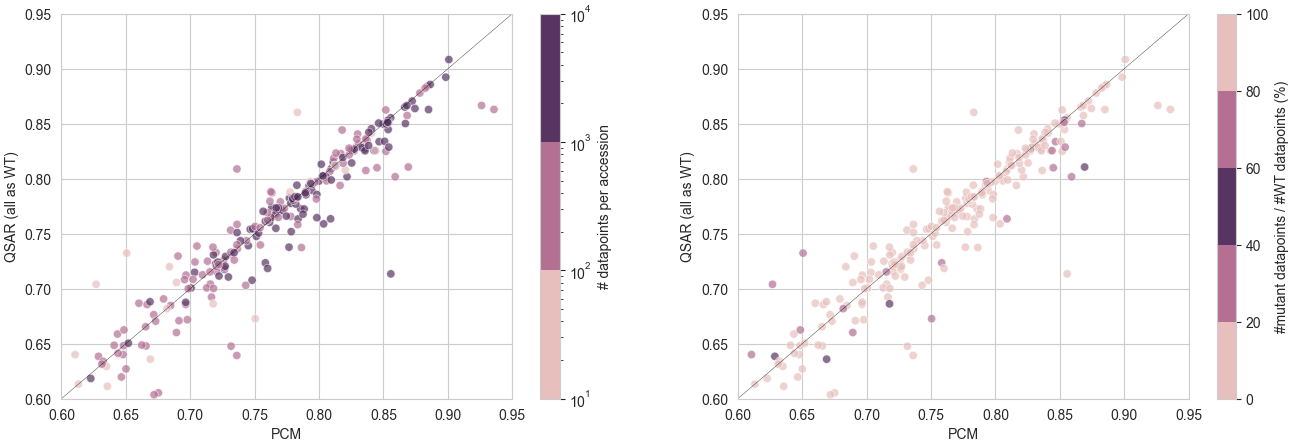

In [232]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=0.7,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))

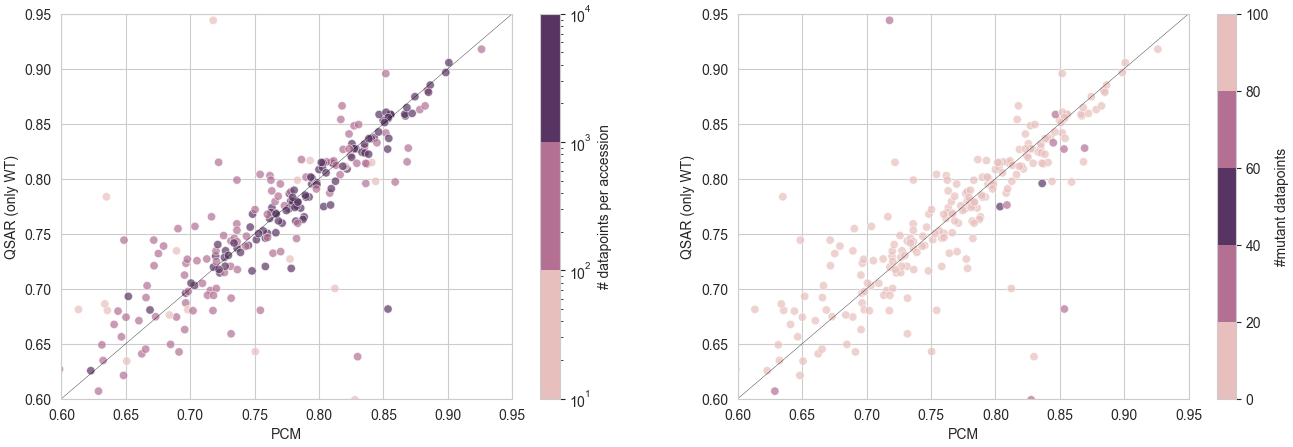

In [233]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=0.7,
                      palette=palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints')


_ = ax1.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))

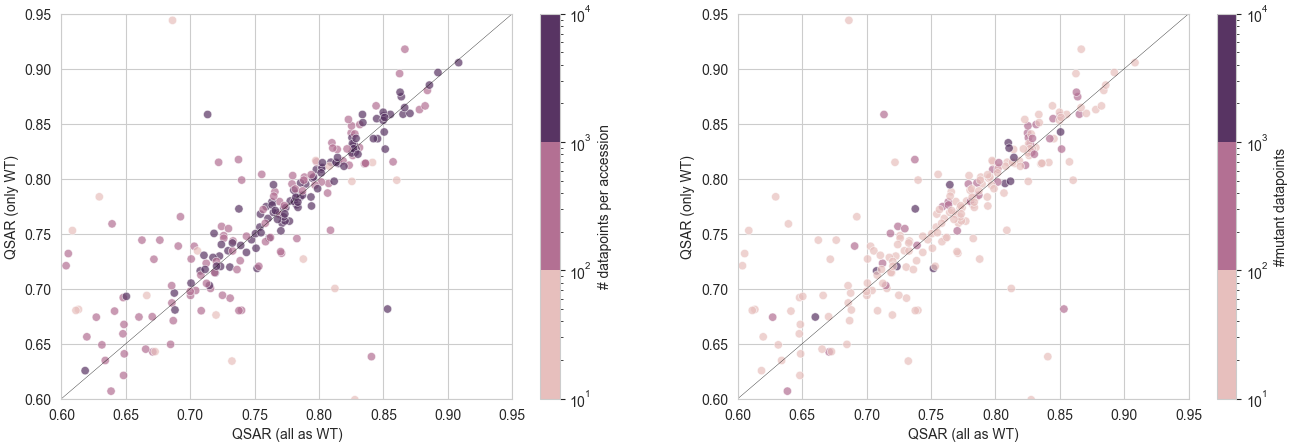

In [234]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='num_datapoints_mutants',
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      data=scatter_data,
                      alpha=0.7,
                      palette=div_palette,
                      ax=axes[1])
norm2 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm2 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints')


_ = ax1.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))

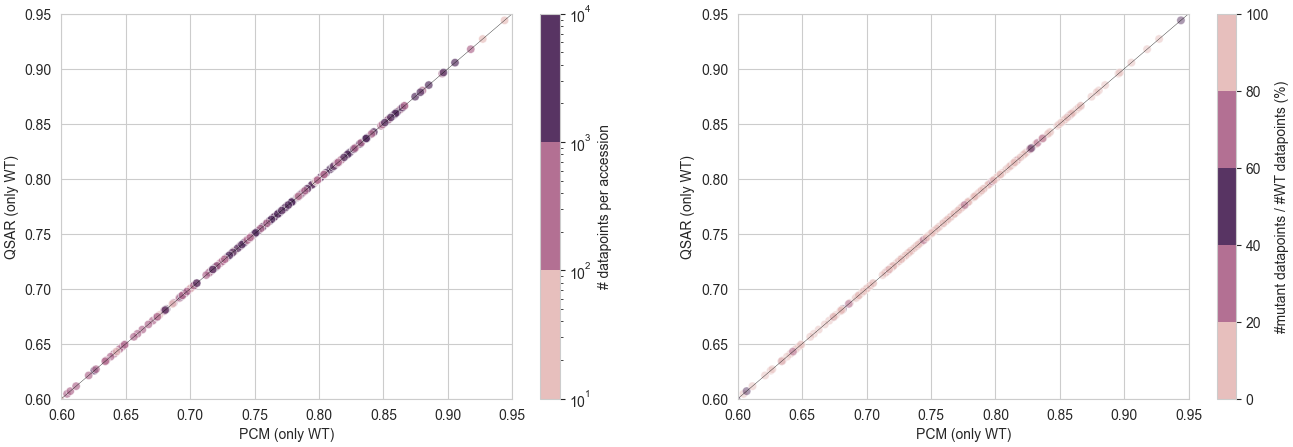

In [235]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_False_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_False_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=0.5,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM (only WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM (only WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))

Since the data contains only WT, adding protein descriptors does not confer PCM with any advantage over QSAR modelling. 

## Common subsets

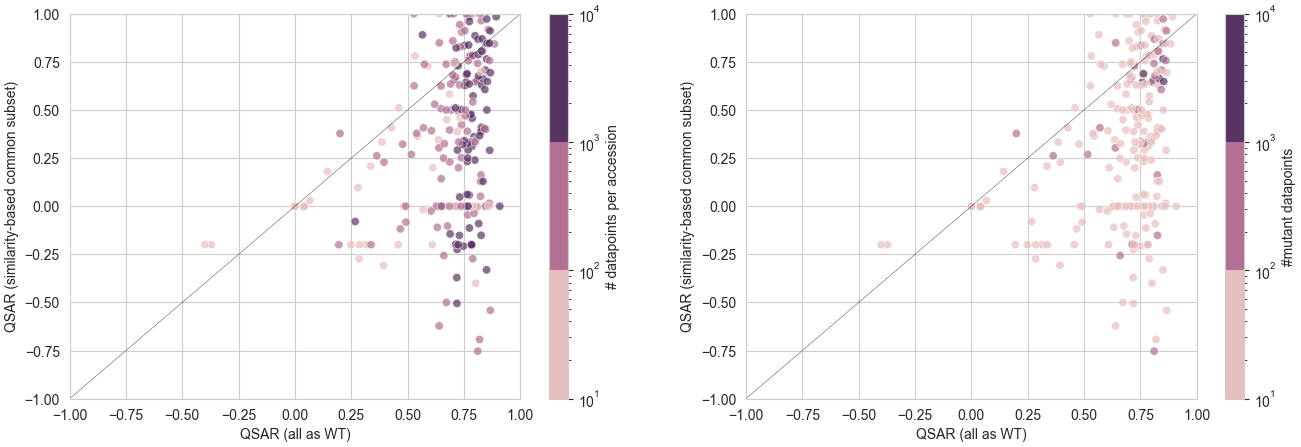

In [236]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='num_datapoints_mutants',
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      data=scatter_data,
                      alpha=0.7,
                      palette=palette,
                      ax=axes[1])
norm2 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm2 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints')


_ = ax1.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax2.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

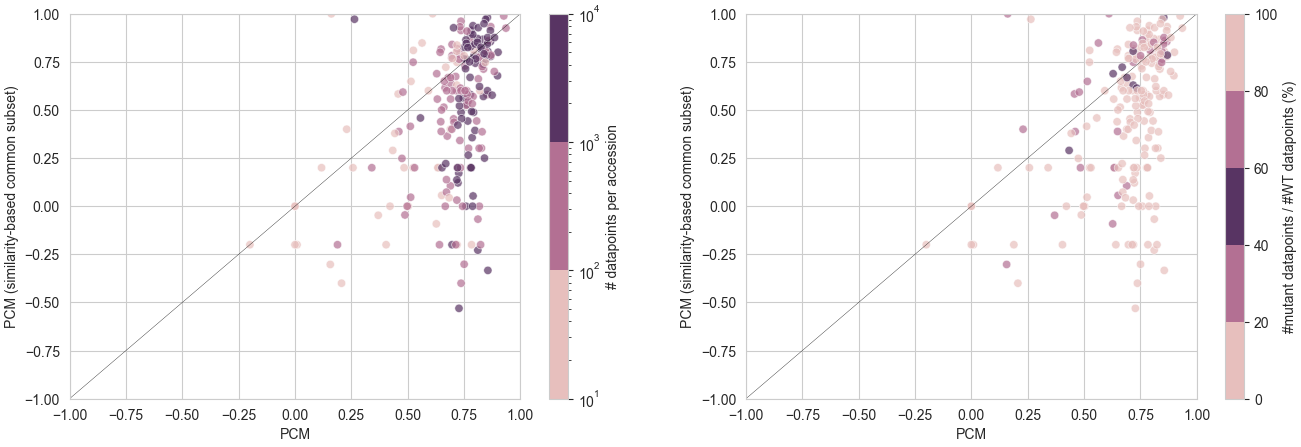

In [237]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=0.7,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax2.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

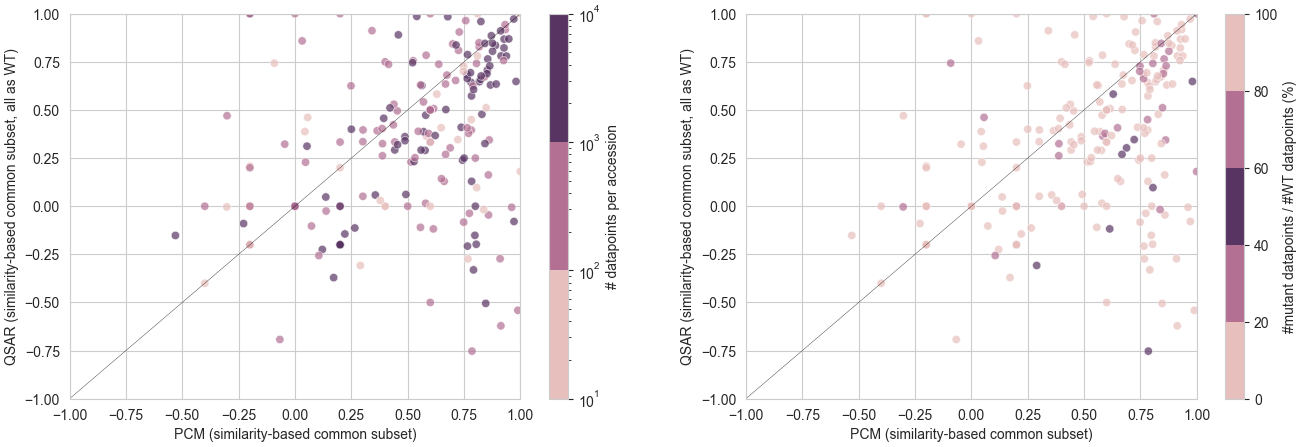

In [238]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=0.7,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax2.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

## LOMO cross-validation

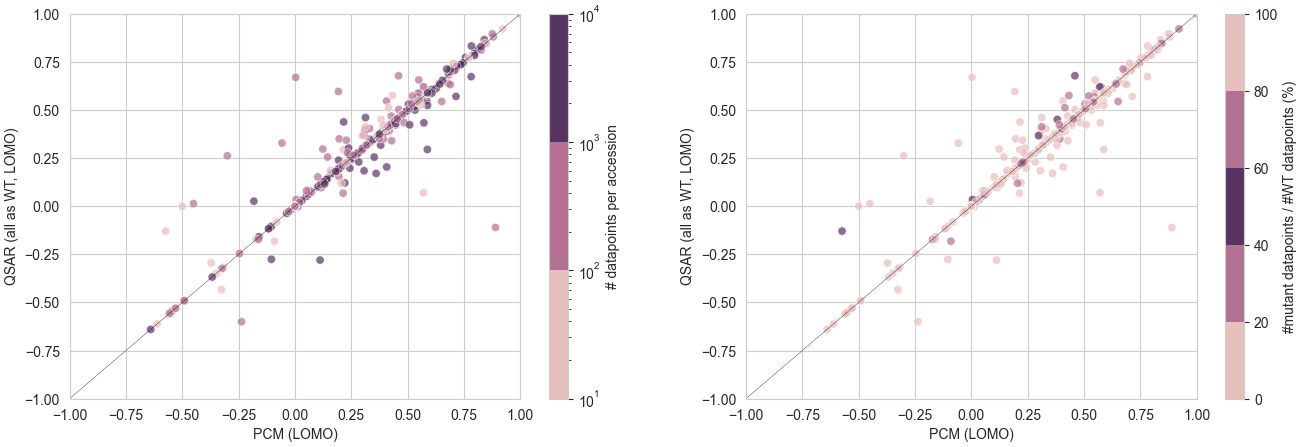

In [239]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_per_mutant',
                      y='Pearson_r_QSAR_complete_True_per_mutant',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_per_mutant',
                      y='Pearson_r_QSAR_complete_True_per_mutant',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=0.7,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM (LOMO)', ylabel='QSAR (all as WT, LOMO)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax2.set(xlabel='PCM (LOMO)', ylabel='QSAR (all as WT, LOMO)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

## Protein families

In [36]:
from papyrus_scripts import read_protein_set
from papyrus_scripts.preprocess import equalize_cell_size_in_column

In [37]:
proteins = read_protein_set()

In [38]:
proteins = proteins[proteins.target_id.str.endswith('_WT')].reset_index(drop=True)
proteins['accession'] = proteins.target_id.str.split('_').str[0]

In [39]:
proteins = pd.concat([proteins,
                      pd.DataFrame(equalize_cell_size_in_column(proteins.Classification.str.split('->')).tolist(), columns=[f'L{i}' for i in range(1, 7)])
                      ],
                     axis=1)

In [40]:
annotation = pd.Series([''] * proteins.shape[0])
annotation.loc[proteins.L1 == 'Ion channel'] = 'Ion Channel'
annotation.loc[proteins.L2 == 'Nuclear receptor'] = 'Nuclear Receptor'
annotation.loc[proteins.L2 == 'Family A G protein-coupled receptor'] = 'Family A GPCR'
annotation.loc[proteins.L3 == 'Protein Kinase'] = 'Protein Kinase'
proteins['color'] = annotation

In [41]:
scatter_data = scatter_data.merge(proteins, on='accession')

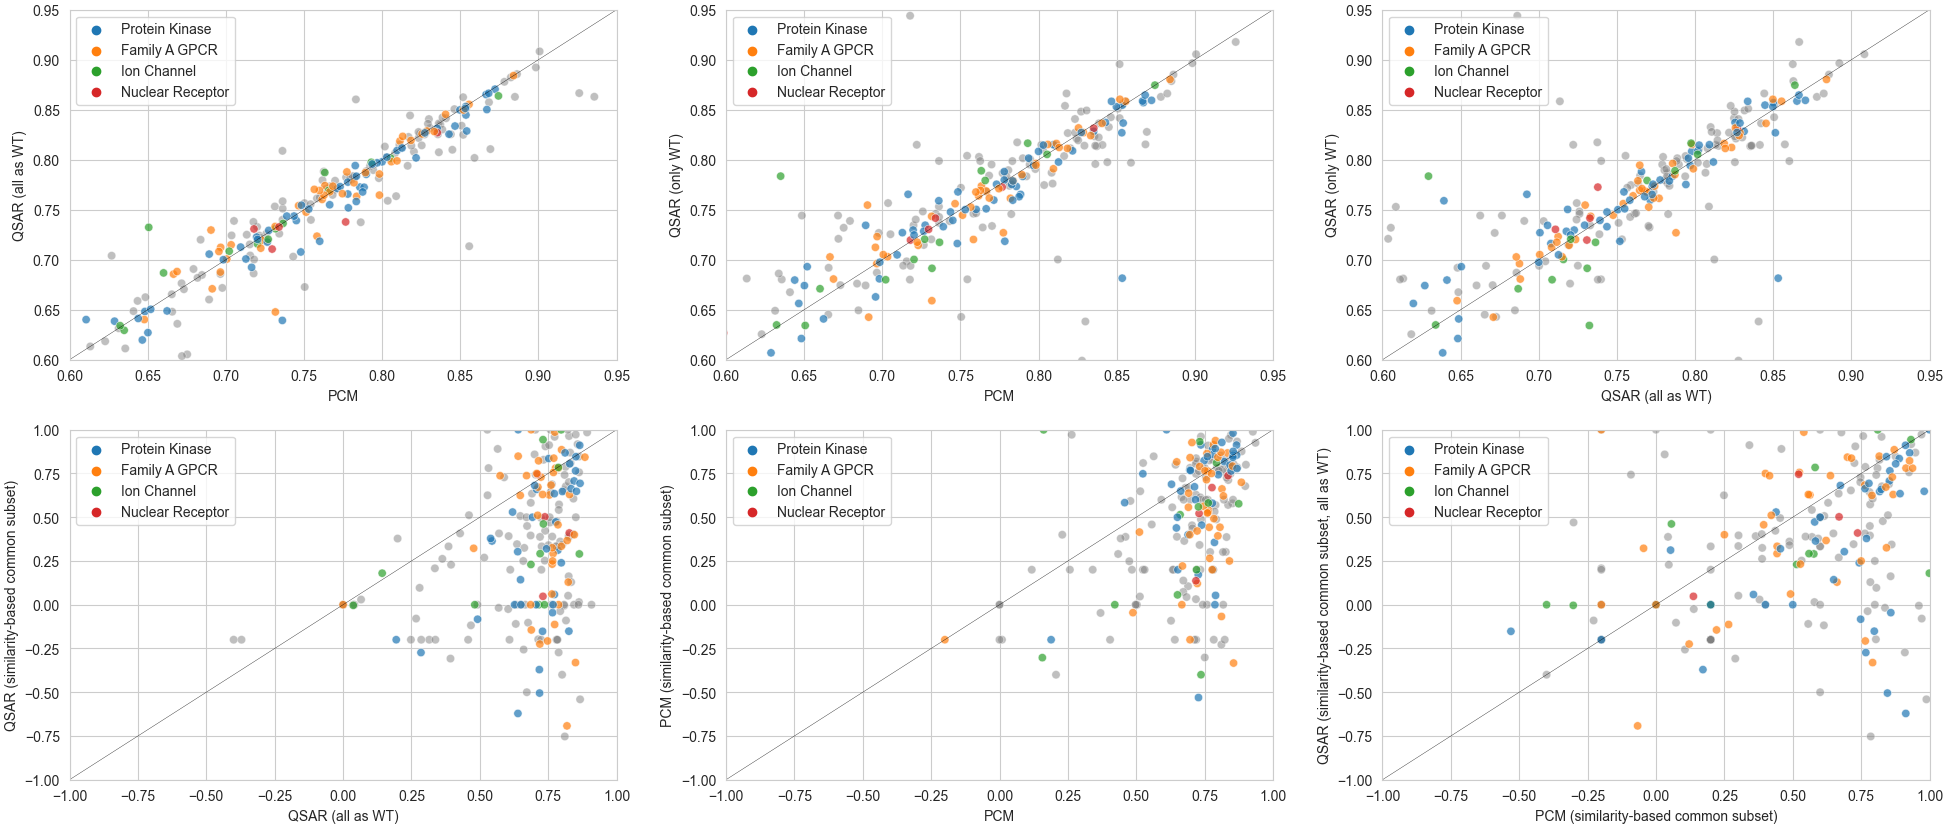

In [230]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 10))
palette = matplotlib.colors.ListedColormap(['grey']).colors
palette2 = sns.color_palette(as_cmap=True)[:4]


for iy, ix in np.ndindex(axes.shape):
    # Plot identity lines
    axes[iy, ix].plot(np.linspace(-100, 100, 100),
                      np.linspace(-100, 100, 100),
                      linestyle='solid', linewidth=0.25,
                      color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='color',
                      data=scatter_data[scatter_data.color == ''],
                      palette=palette,
                      alpha=0.5,
                      ax=axes[0, 0])
sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='color',
                      data=scatter_data[scatter_data.color != ''],
                      palette=palette2,
                      alpha=0.7,
                      ax=axes[0, 0])
sns.lineplot()
ax1.legend_.set_title(None)

ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='color',
                      data=scatter_data[scatter_data.color == ''],
                      palette=palette,
                      alpha=0.5,
                      ax=axes[0, 1])
sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='color',
                      data=scatter_data[scatter_data.color != ''],
                      palette=palette2,
                      alpha=0.7,
                      ax=axes[0, 1])
ax2.legend_.set_title(None)

ax3 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='color',
                      data=scatter_data[scatter_data.color == ''], 
                      palette=palette,
                      alpha=0.5,
                      ax=axes[0, 2])
sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='color',
                      data=scatter_data[scatter_data.color != ''], 
                      palette=palette2,
                      alpha=0.7,
                      ax=axes[0, 2])
ax3.legend_.set_title(None)

ax4 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='color',
                      data=scatter_data[scatter_data.color == ''], 
                      palette=palette,
                      alpha=0.5,
                      ax=axes[1, 0])
sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='color',
                      data=scatter_data[scatter_data.color != ''], 
                      palette=palette2,
                      alpha=0.7,
                      ax=axes[1, 0])
ax4.legend_.set_title(None)

ax5 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='color',
                      data=scatter_data[scatter_data.color == ''],
                      palette=palette,
                      alpha=0.5,
                      ax=axes[1, 1])
sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='color',
                      data=scatter_data[scatter_data.color != ''],
                      palette=palette2,
                      alpha=0.7,
                      ax=axes[1, 1])
ax5.legend_.set_title(None)

ax6 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='color',
                      data=scatter_data[scatter_data.color == ''], 
                      palette=palette,
                      alpha=0.5,
                      ax=axes[1, 2])
sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='color',
                      data=scatter_data[scatter_data.color != ''], 
                      palette=palette2,
                      alpha=0.7,
                      ax=axes[1, 2])
ax6.legend_.set_title(None)



_ = ax1.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax3.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax4.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax5.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax6.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

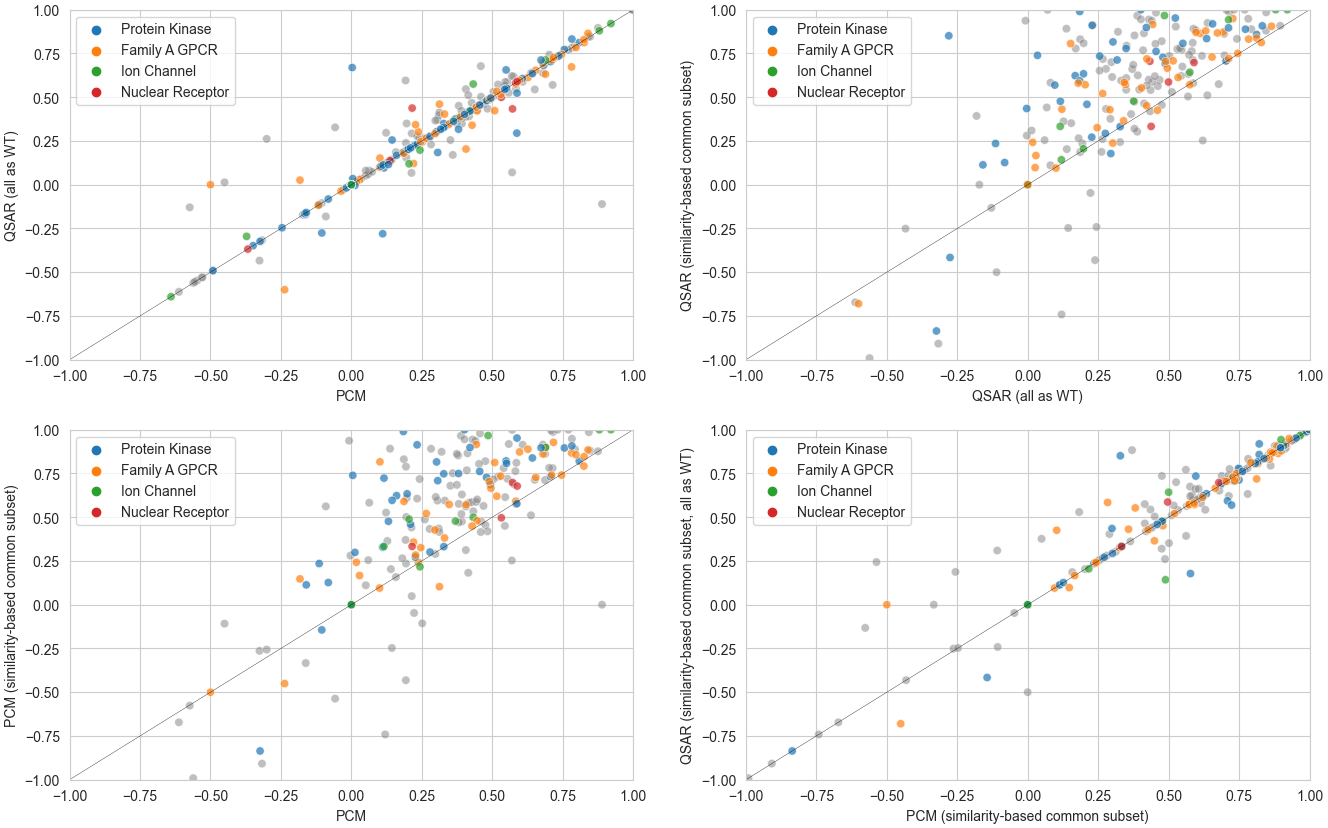

In [279]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
palette = matplotlib.colors.ListedColormap(['grey']).colors
palette2 = sns.color_palette(as_cmap=True)[:4]

# Plot identity lines
for iy, ix in np.ndindex(axes.shape):
    axes[iy, ix].plot(np.linspace(-100, 100, 100),
                      np.linspace(-100, 100, 100),
                      linestyle='solid', linewidth=0.25,
                      color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_per_mutant',
                      y='Pearson_r_QSAR_complete_True_per_mutant',
                      hue='color',
                      data=scatter_data[scatter_data.color == ''],
                      palette=palette,
                      alpha=0.5,
                      ax=axes[0, 0])
sns.scatterplot(x='Pearson_r_PCM_complete_True_per_mutant',
                      y='Pearson_r_QSAR_complete_True_per_mutant',
                      hue='color',
                      data=scatter_data[scatter_data.color != ''],
                      palette=palette2,
                      alpha=0.7,
                      ax=axes[0, 0])
ax1.legend_.set_title(None)


ax2 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_per_mutant',
                      y='Pearson_r_QSAR_common_True_per_mutant',
                      hue='color',
                      data=scatter_data[scatter_data.color == ''], 
                      palette=palette,
                      alpha=0.5,
                      ax=axes[0, 1])
sns.scatterplot(x='Pearson_r_QSAR_complete_True_per_mutant',
                      y='Pearson_r_QSAR_common_True_per_mutant',
                      hue='color',
                      data=scatter_data[scatter_data.color != ''], 
                      palette=palette2,
                      alpha=0.7,
                      ax=axes[0, 1])
ax2.legend_.set_title(None)

ax3 = sns.scatterplot(x='Pearson_r_PCM_complete_True_per_mutant',
                      y='Pearson_r_PCM_common_True_per_mutant',
                      hue='color',
                      data=scatter_data[scatter_data.color == ''],
                      palette=palette,
                      alpha=0.5,
                      ax=axes[1, 0])
sns.scatterplot(x='Pearson_r_PCM_complete_True_per_mutant',
                      y='Pearson_r_PCM_common_True_per_mutant',
                      hue='color',
                      data=scatter_data[scatter_data.color != ''],
                      palette=palette2,
                      alpha=0.7,
                      ax=axes[1, 0])
ax3.legend_.set_title(None)

ax4 = sns.scatterplot(x='Pearson_r_PCM_common_True_per_mutant',
                      y='Pearson_r_QSAR_common_True_per_mutant',
                      hue='color',
                      data=scatter_data[scatter_data.color == ''], 
                      palette=palette,
                      alpha=0.5,
                      ax=axes[1, 1])
sns.scatterplot(x='Pearson_r_PCM_common_True_per_mutant',
                      y='Pearson_r_QSAR_common_True_per_mutant',
                      hue='color',
                      data=scatter_data[scatter_data.color != ''], 
                      palette=palette2,
                      alpha=0.7,
                      ax=axes[1, 1])
ax4.legend_.set_title(None)

_ = ax1.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(-1, 1), ylim=(-1, 1))
_ = ax2.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax3.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax4.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

## Interesting targets

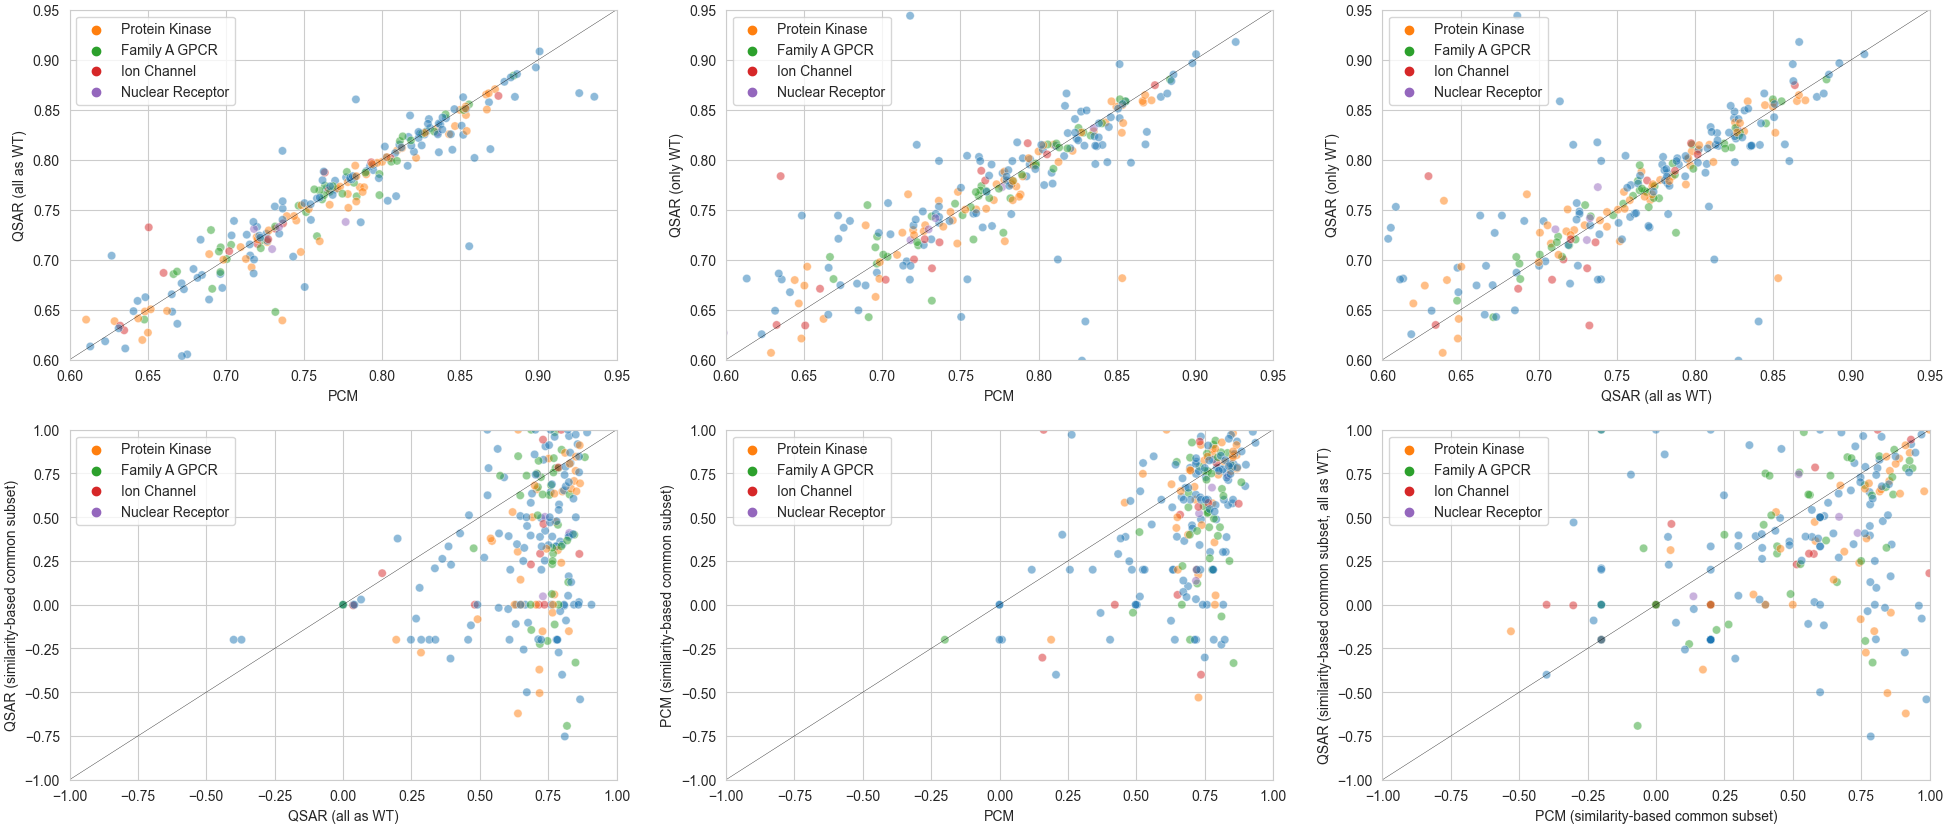

In [280]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 10)) 

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='color',
                      data=scatter_data, 
                      alpha=0.5,
                      ax=axes[0, 0])
ax1.legend_.set_title(None)

ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='color',
                      data=scatter_data,
                      alpha=0.5,
                      ax=axes[0, 1])
ax2.legend_.set_title(None)

ax3 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='color',
                      data=scatter_data, 
                      alpha=0.5,
                      ax=axes[0, 2])
ax3.legend_.set_title(None)

ax4 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='color',
                      data=scatter_data, 
                      alpha=0.5,
                      ax=axes[1, 0])
ax4.legend_.set_title(None)

ax5 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='color',
                      data=scatter_data,
                      alpha=0.5,
                      ax=axes[1, 1])
ax5.legend_.set_title(None)

ax6 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='color',
                      data=scatter_data, 
                      alpha=0.5,
                      ax=axes[1, 2])
ax6.legend_.set_title(None)

_ = ax1.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax3.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax4.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax5.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax6.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

## Differences in bioactivity

In [281]:
# TODO: change path of stats to generic, as they are created in main.py

In [282]:
stats = pd.read_csv('C:/Users/ojbeq/Downloads/stats_file_All.txt', sep='\t')
stats_var = pd.read_csv('C:/Users/ojbeq/Downloads/stats_per_variant_round2.txt', sep='\t')

Obtain color scales of he next plots:
- `avg_WT`: the average pchembl value of WT proteins only
- `weighted_avg_all`: the weighted average of pchembl value (weighted by number of datapoints for each variant)
- `abs_weighted_diff`: the absolute difference between the weighted average of the mutants pchembl values and the average pchembl values of the corresponding WT accession
- `abs_diff`: the absolute difference betwen the **un**weighted average of the mutants pchembl values and the average pchembl values of the corresponding WT accession
- `max_abs_diff`: the maximum absolute difference between the average pchembl value of mutants and the average of the pchembl of their corresponding WT accession

In [283]:
# Obtain the average pchembl of the WT proteins only
avg_WT = stats[stats.target_id.str.endswith('_WT')][['accession', 'mean_pchembl']].set_index('accession')

In [284]:
# Obtain weighted mean of all variants (including WT)
stats_datapoints = pd.concat([stats_var[['accession', 'variant', 'connectivity_variant_percentage']].set_index('variant'),
                              stats[['target_id', 'mean_pchembl']].set_index('target_id'),
                              ],
                             axis=1)
# Define a lambda function to compute the weighted mean:
weighted_mean = lambda x: np.average(x, weights=stats_datapoints.loc[x.index, "connectivity_variant_percentage"])

# Group by accession and calculate weighted average of pchembl value
weighted_avg_all = stats_datapoints.groupby(["accession"]).agg(pchembl_weighted_mean=("mean_pchembl", weighted_mean))

In [285]:
# Obtain weighted of mutants only (no WT)
mutant_datapoints = pd.concat([stats_var[~stats_var.variant.str.endswith('_WT')][['accession', 'variant', 'connectivity_variant_percentage']].set_index('variant'),
                               stats[~stats.target_id.str.endswith('_WT')][['target_id', 'mean_pchembl']].set_index('target_id'),
                               ],
                              axis=1)
# Define a lambda function to compute the weighted mean:
weighted_mean_var = lambda x: np.average(x, weights=mutant_datapoints.loc[x.index, "connectivity_variant_percentage"])

# Group by accession and calculate weighted average of pchembl value
weighted_pchembl_var = mutant_datapoints.groupby(["accession"]).agg(pchembl_weighted_mean=("mean_pchembl", weighted_mean_var))

# Obtain deviation to WT
abs_weighted_diff = (pd.concat([weighted_pchembl_var,
                                        stats[stats.target_id.str.endswith('_WT')][['accession', 'mean_pchembl']].set_index('accession')],
                                       axis=1).dropna()
                             .diff(axis=1)
                             .iloc[:, 1:]
                             .abs()
                             .rename(columns={'mean_pchembl': 'abs_weighted_diff_pchembl_mutant-WT'})
                             )

In [286]:
# Obtain deviation to WT (first group by accession and calculate average of pchembl value)
abs_diff = (pd.concat([mutant_datapoints.groupby(["accession"]).agg(pchembl_mean=("mean_pchembl", "mean")),
                                        stats[stats.target_id.str.endswith('_WT')][['accession', 'mean_pchembl']].set_index('accession')],
                                       axis=1).dropna()
                             .diff(axis=1)
                             .iloc[:, 1:]
                             .abs()
                             .rename(columns={'mean_pchembl': 'abs_diff_pchembl_mutant-WT'})
                             )

In [287]:
# Obtain the maximum deviation to WT (no grouping by accession)
max_abs_diff = (stats[~stats.target_id.str.endswith('_WT')][['accession', 'target_id', 'mean_pchembl']]
                .rename(columns={'mean_pchembl': 'mean_pchembl_mutant'})
                .merge(stats[stats.target_id.str.endswith('_WT')][['accession', 'mean_pchembl']]
                        .rename(columns={'mean_pchembl': 'mean_pchembl_WT'}),
                       on='accession')
                )
max_abs_diff['max_abs_diff_pchembl_mutant-WT'] = (max_abs_diff.mean_pchembl_mutant - max_abs_diff.mean_pchembl_WT).abs()
max_abs_diff = (max_abs_diff.drop(columns=['mean_pchembl_mutant', 'mean_pchembl_WT'])
                .groupby('accession')
                .agg({'max_abs_diff_pchembl_mutant-WT': 'max'})
                )

In [288]:
annotations = pd.concat([avg_WT,
                         weighted_avg_all,
                         abs_weighted_diff,
                         abs_diff,
                         max_abs_diff],
                        axis=1)

In [289]:
annotated_scatter_data = scatter_data.merge(annotations, on='accession')

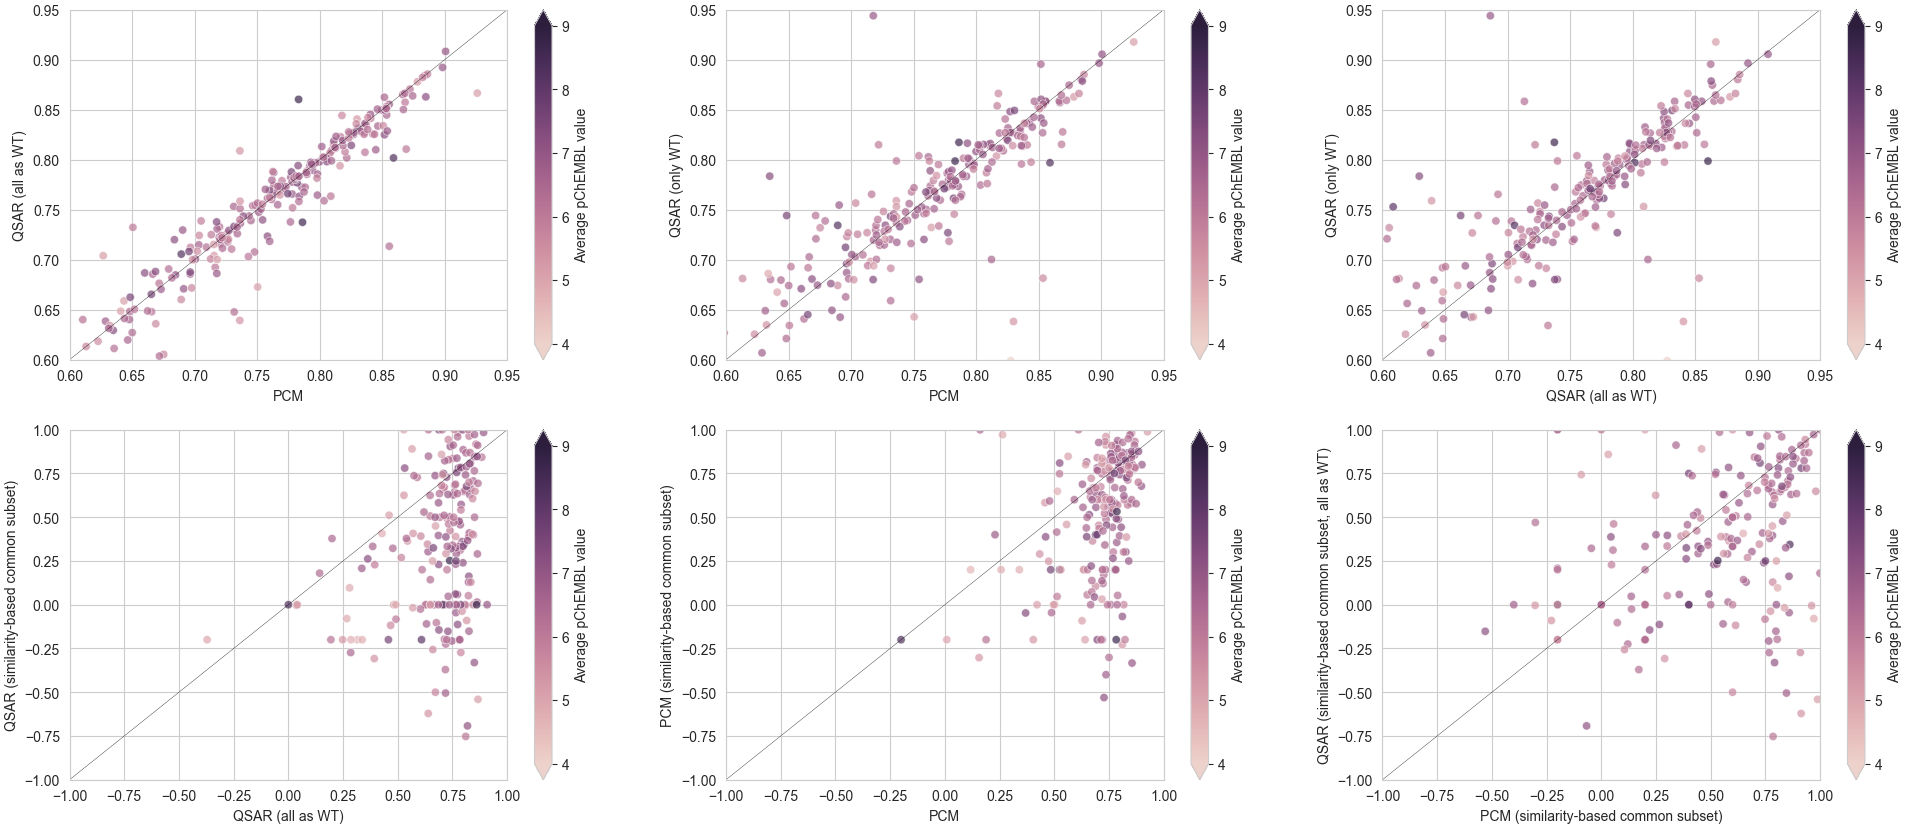

In [290]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 10))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')
 
ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='mean_pchembl',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[0, 0])
ax1.legend_.set_title(None)
norm1 = matplotlib.colors.Normalize(4, 9)
sm1 = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True),
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='Average pChEMBL value', extend='both')

ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='mean_pchembl',
                      data=annotated_scatter_data,
                      alpha=0.7,
                      ax=axes[0, 1])
ax2.legend_.set_title(None)
ax2.get_legend().remove()
ax2.figure.colorbar(sm1, ax=ax2, label='Average pChEMBL value', extend='both')

ax3 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='mean_pchembl',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[0, 2])
ax3.legend_.set_title(None)
ax3.get_legend().remove()
ax3.figure.colorbar(sm1, ax=ax3, label='Average pChEMBL value', extend='both')

ax4 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='mean_pchembl',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[1, 0])
ax4.legend_.set_title(None)
ax4.get_legend().remove()
ax4.figure.colorbar(sm1, ax=ax4, label='Average pChEMBL value', extend='both')

ax5 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='mean_pchembl',
                      data=annotated_scatter_data,
                      alpha=0.7,
                      ax=axes[1, 1])
ax5.legend_.set_title(None)
ax5.get_legend().remove()
ax5.figure.colorbar(sm1, ax=ax5, label='Average pChEMBL value', extend='both')

ax6 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='mean_pchembl',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[1, 2])
ax6.legend_.set_title(None)
ax6.get_legend().remove()
ax6.figure.colorbar(sm1, ax=ax6, label='Average pChEMBL value', extend='both')

_ = ax1.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax3.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax4.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax5.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax6.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

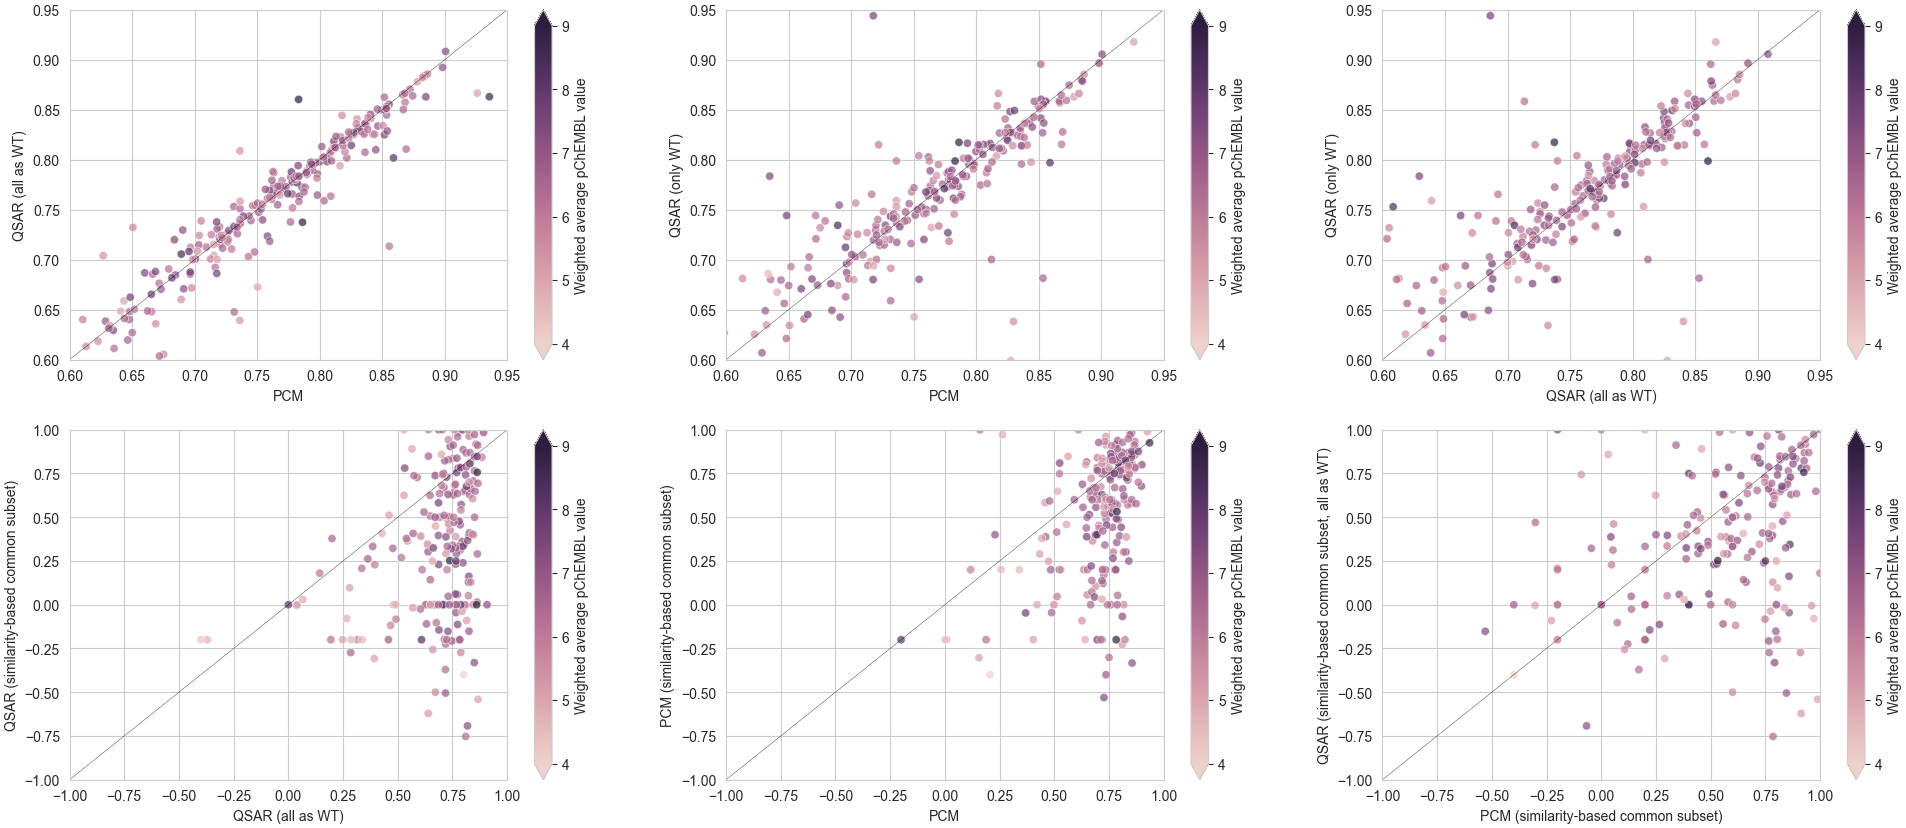

In [291]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 10)) 

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='pchembl_weighted_mean',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[0, 0])
ax1.legend_.set_title(None)
norm1 = matplotlib.colors.Normalize(4, 9)
sm1 = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True),
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='Weighted average pChEMBL value', extend='both')

ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='pchembl_weighted_mean',
                      data=annotated_scatter_data,
                      alpha=0.7,
                      ax=axes[0, 1])
ax2.legend_.set_title(None)
ax2.get_legend().remove()
ax2.figure.colorbar(sm1, ax=ax2, label='Weighted average pChEMBL value', extend='both')

ax3 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='pchembl_weighted_mean',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[0, 2])
ax3.legend_.set_title(None)
ax3.get_legend().remove()
ax3.figure.colorbar(sm1, ax=ax3, label='Weighted average pChEMBL value', extend='both')

ax4 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='pchembl_weighted_mean',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[1, 0])
ax4.legend_.set_title(None)
ax4.get_legend().remove()
ax4.figure.colorbar(sm1, ax=ax4, label='Weighted average pChEMBL value', extend='both')

ax5 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='pchembl_weighted_mean',
                      data=annotated_scatter_data,
                      alpha=0.7,
                      ax=axes[1, 1])
ax5.legend_.set_title(None)
ax5.get_legend().remove()
ax5.figure.colorbar(sm1, ax=ax5, label='Weighted average pChEMBL value', extend='both')

ax6 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='pchembl_weighted_mean',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[1, 2])
ax6.legend_.set_title(None)
ax6.get_legend().remove()
ax6.figure.colorbar(sm1, ax=ax6, label='Weighted average pChEMBL value', extend='both')

_ = ax1.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax3.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax4.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax5.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax6.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

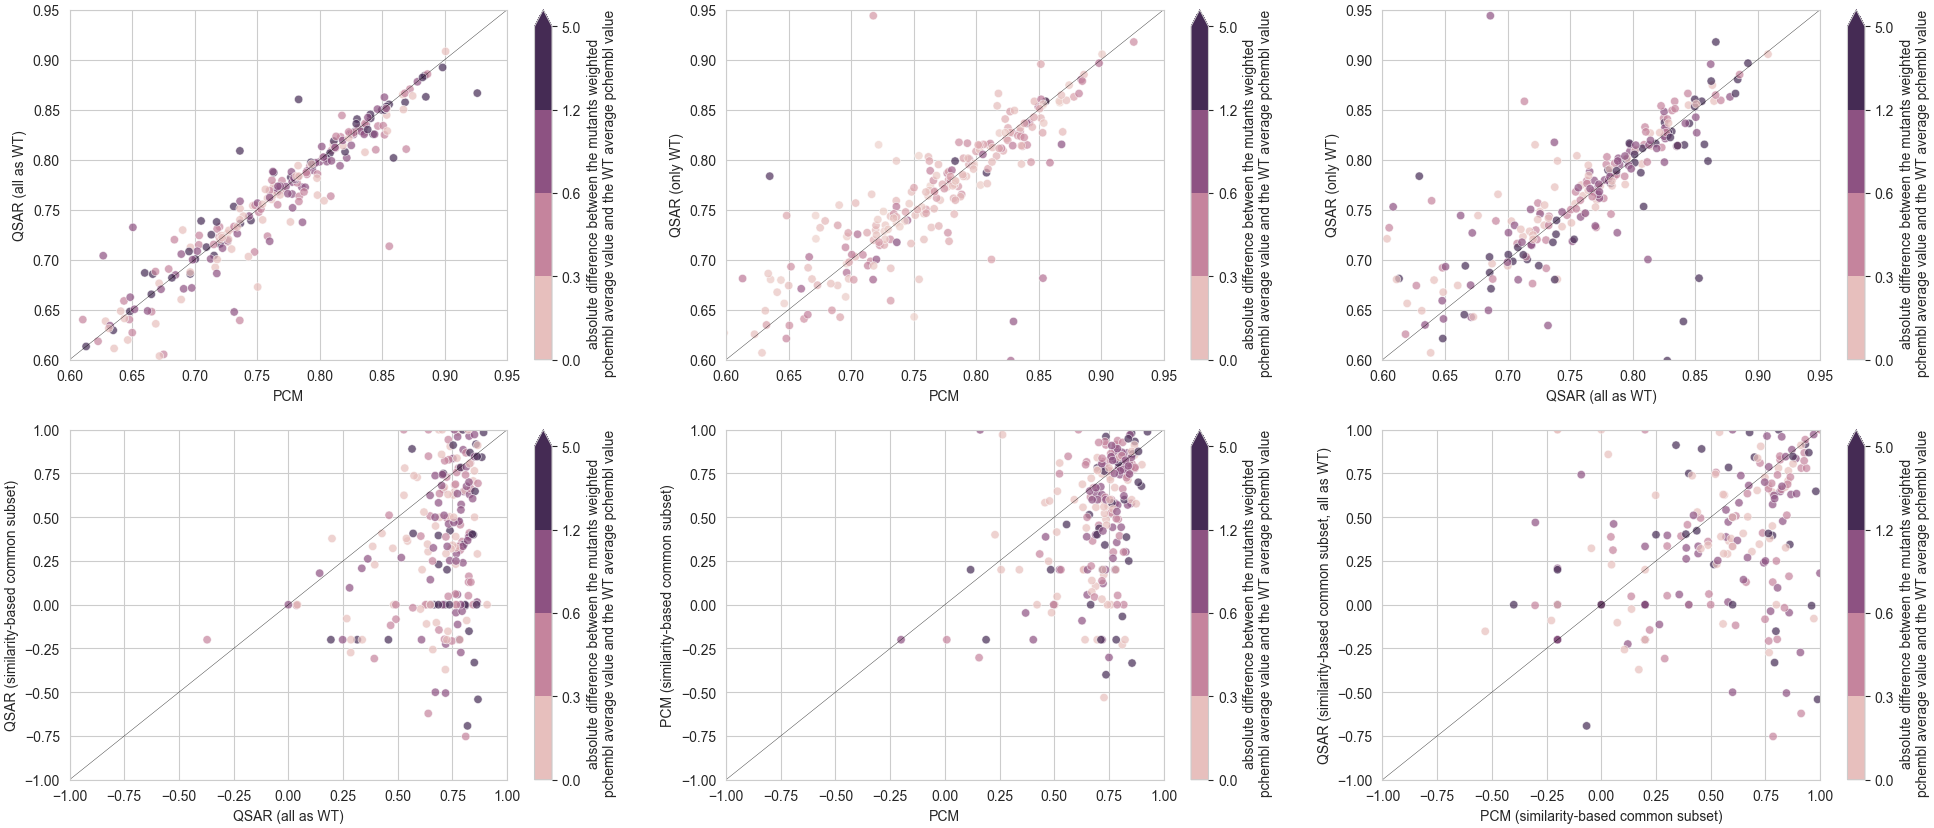

In [292]:
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::70])
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 10))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='abs_weighted_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[0, 0])
ax1.legend_.set_title(None)
norm1 = matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max')
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='absolute difference between the mutants weighted\npchembl average value and the WT average pchembl value')

ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='abs_weighted_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data,
                      alpha=0.7,
                      ax=axes[0, 1])
ax2.legend_.set_title(None)
ax2.get_legend().remove()
ax2.figure.colorbar(sm1, ax=ax2, label='absolute difference between the mutants weighted\npchembl average value and the WT average pchembl value')

ax3 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='abs_weighted_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[0, 2])
ax3.legend_.set_title(None)
ax3.get_legend().remove()
ax3.figure.colorbar(sm1, ax=ax3, label='absolute difference between the mutants weighted\npchembl average value and the WT average pchembl value')

ax4 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='abs_weighted_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[1, 0])
ax4.legend_.set_title(None)
ax4.get_legend().remove()
ax4.figure.colorbar(sm1, ax=ax4, label='absolute difference between the mutants weighted\npchembl average value and the WT average pchembl value')

ax5 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='abs_weighted_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data,
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[1, 1])
ax5.legend_.set_title(None)
ax5.get_legend().remove()
ax5.figure.colorbar(sm1, ax=ax5, label='absolute difference between the mutants weighted\npchembl average value and the WT average pchembl value')

ax6 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='abs_weighted_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[1, 2])
ax6.legend_.set_title(None)
ax6.get_legend().remove()
ax6.figure.colorbar(sm1, ax=ax6, label='absolute difference between the mutants weighted\npchembl average value and the WT average pchembl value')

_ = ax1.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax3.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax4.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax5.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax6.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

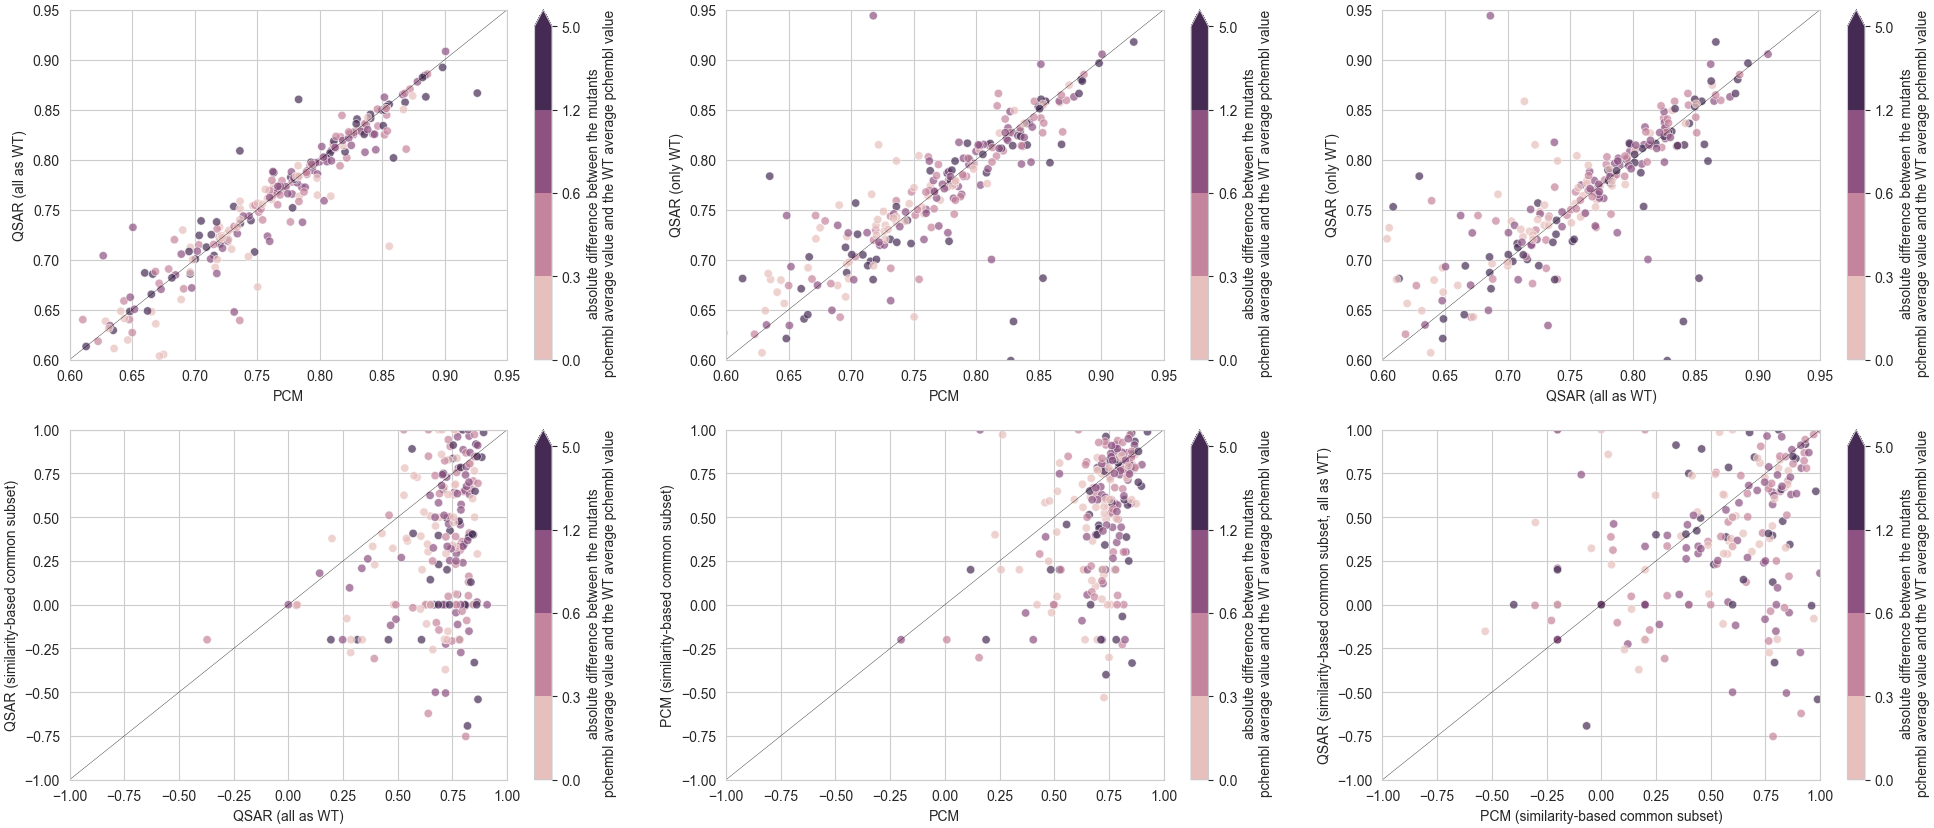

In [293]:
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::70])
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 10))

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[0, 0])
ax1.legend_.set_title(None)
norm1 = matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max')
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='absolute difference between the mutants\npchembl average value and the WT average pchembl value')

ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data,
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[0, 1])
ax2.legend_.set_title(None)
ax2.get_legend().remove()
ax2.figure.colorbar(sm1, ax=ax2, label='absolute difference between the mutants\npchembl average value and the WT average pchembl value')

ax3 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[0, 2])
ax3.legend_.set_title(None)
ax3.get_legend().remove()
ax3.figure.colorbar(sm1, ax=ax3, label='absolute difference between the mutants\npchembl average value and the WT average pchembl value')

ax4 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[1, 0])
ax4.legend_.set_title(None)
ax4.get_legend().remove()
ax4.figure.colorbar(sm1, ax=ax4, label='absolute difference between the mutants\npchembl average value and the WT average pchembl value')

ax5 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data,
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[1, 1])
ax5.legend_.set_title(None)
ax5.get_legend().remove()
ax5.figure.colorbar(sm1, ax=ax5, label='absolute difference between the mutants\npchembl average value and the WT average pchembl value')

ax6 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max'),
                      palette=palette,
                      ax=axes[1, 2])
ax6.legend_.set_title(None)
ax6.get_legend().remove()
ax6.figure.colorbar(sm1, ax=ax6, label='absolute difference between the mutants\npchembl average value and the WT average pchembl value')

_ = ax1.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax3.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax4.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax5.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax6.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

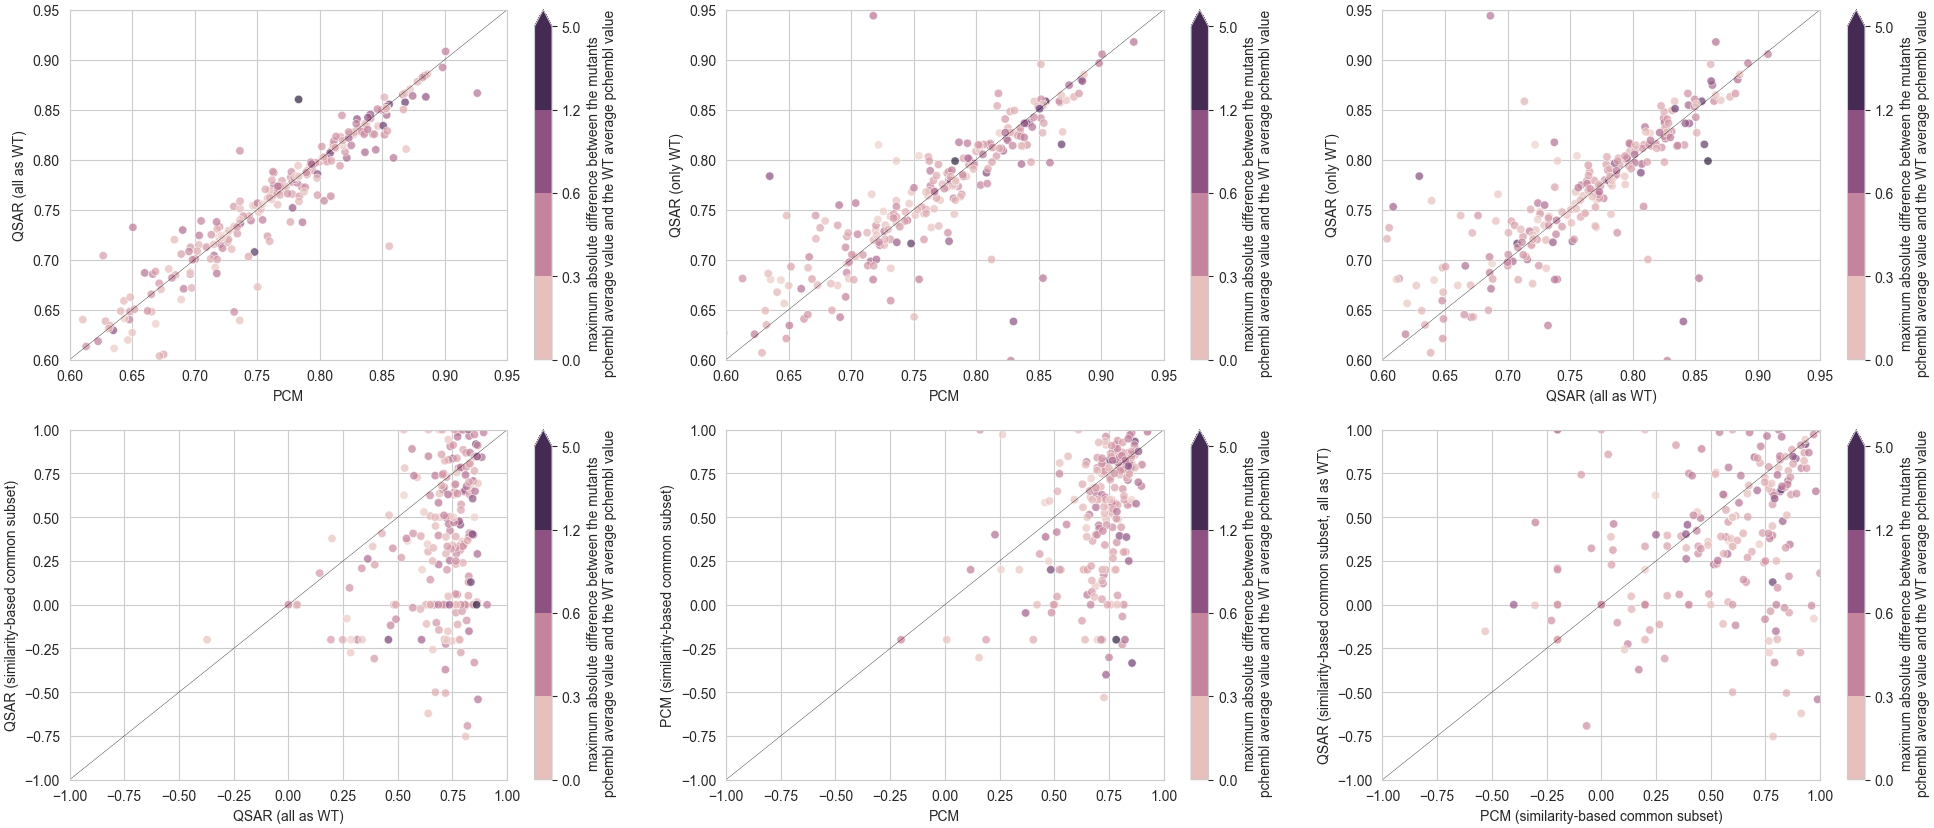

In [294]:
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::70])
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 10)) 

# Plot identity lines
for iy in np.ndindex(axes.shape):
    axes[iy].plot(np.linspace(-100, 100, 100),
                  np.linspace(-100, 100, 100),
                  linestyle='solid', linewidth=0.25,
                  color='black')

ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='max_abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[0, 0])
ax1.legend_.set_title(None)
norm1 = matplotlib.colors.BoundaryNorm(boundaries=[0, 0.3, 0.6, 1.2, 5], ncolors=5, extend='max')
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='maximum absolute difference between the mutants\npchembl average value and the WT average pchembl value')

ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='max_abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data,
                      alpha=0.7,
                      ax=axes[0, 1])
ax2.legend_.set_title(None)
ax2.get_legend().remove()
ax2.figure.colorbar(sm1, ax=ax2, label='maximum absolute difference between the mutants\npchembl average value and the WT average pchembl value')

ax3 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='max_abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[0, 2])
ax3.legend_.set_title(None)
ax3.get_legend().remove()
ax3.figure.colorbar(sm1, ax=ax3, label='maximum absolute difference between the mutants\npchembl average value and the WT average pchembl value')

ax4 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='max_abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[1, 0])
ax4.legend_.set_title(None)
ax4.get_legend().remove()
ax4.figure.colorbar(sm1, ax=ax4, label='maximum absolute difference between the mutants\npchembl average value and the WT average pchembl value')

ax5 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='max_abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data,
                      alpha=0.7,
                      ax=axes[1, 1])
ax5.legend_.set_title(None)
ax5.get_legend().remove()
ax5.figure.colorbar(sm1, ax=ax5, label='maximum absolute difference between the mutants\npchembl average value and the WT average pchembl value')

ax6 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='max_abs_diff_pchembl_mutant-WT',
                      data=annotated_scatter_data, 
                      alpha=0.7,
                      ax=axes[1, 2])
ax6.legend_.set_title(None)
ax6.get_legend().remove()
ax6.figure.colorbar(sm1, ax=ax6, label='maximum absolute difference between the mutants\npchembl average value and the WT average pchembl value')

_ = ax1.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax3.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax4.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax5.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax6.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )